<a href="https://colab.research.google.com/github/yajima-yasutoshi/Model/blob/main/20250716/%E3%83%93%E3%83%B3%E3%83%91%E3%83%83%E3%82%AD%E3%83%B3%E3%82%B0%E5%95%8F%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#準備

In [ ]:
%%capture
# python-mip ライブラリをインストールする
!pip install mip

# 必要なライブラリをインポートする
import mip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#ビンパッキング問題

この講義では、「ビンパッキング問題 (Bin Packing Problem, BPP)」について学びます。

本講義の目標は以下の通りです。

1.  ビンパッキング問題の基本的な概念と、それが実社会でどのように利用されているかを理解する。
2.  ビンパッキング問題を数理モデルとして定式化する手法を習得する。
3.  Pythonの最適化ライブラリ `python-mip` を用いて、ビンパッキング問題を実際に解くプログラミングスキルを身につける。


## 問題の定義

ビンパッキング問題とは、与えられた複数のアイテム（それぞれ異なるサイズまたは重さを持つ）を、容量が均一な複数のビン（容器）に詰める際に、使用するビンの数を最小限に抑えるにはどうすればよいか、という問題である。

  * **入力**:
      * アイテムの集合
  $I = \{0, 1, \dots, n-1\}$
      * 各アイテム $i \\in I$ のサイズ（または重さ） $w\_i$
      * 各ビンの均一な容量$C$
  * **出力**:
      * 各アイテムをどのビンに割り当てるかの決定
  * **目的**:
      * 使用するビンの総数を最小化する

この問題は、組み合わせ最適化問題の中でも
最適化を行うことが非常に困難な問題として知られており、
アイテムの数が増えると厳密な最適解を求めることが
非常に困難になる場合がある。

このような問題は**NP困難**な問題と呼ばれる。

## 簡単な例題

  * アイテムのサイズリスト $W = [4, 8, 1, 4, 2, 1]$
  * ビンの容量 $C = 10$
  
これらのアイテムを、容量10のビンに最小限の数で詰めることを考える。
例えば、以下のような詰め方が考えられる。

  * ビン1: [8, 1, 1] (合計サイズ: 10)
  * ビン2: [4, 4, 2] (合計サイズ: 10)

この例では、2つのビンで全てのアイテムを詰めることができた。

では、
アイテムが増加して、
$$W = [4, 8, 1, 4, 2, 1, 6, 5, 3, 7]$$
となった場合、いくつのビンが最小となるだろうか？


### 実社会での応用例

ビンパッキング問題は、その単純な定義にも関わらず、多くの実社会の問題に応用されている。

  * **物流・輸送**:
      * トラックやコンテナに荷物を積み込む際に、最小限の車両数・コンテナ数で輸送する計画。各荷物がアイテム、トラックやコンテナがビンに相当する。
  * **資源割り当て**:
      * クラウドコンピューティング環境において、複数の仮想マシン（アイテム）を物理サーバー（ビン）に割り当てる際、使用する物理サーバーの台数を最小化する。
      * 広告スペース（ビン）に、異なるサイズの広告（アイテム）を割り当てる。
  * **時間枠スケジューリング**:
      * 複数のタスク（アイテム、処理時間を持つ）を、時間枠（ビン、利用可能時間がある）に割り当てる。

これらの例からわかるように、ビンパッキング問題の考え方は、限られた資源を効率的に利用するための基本的な枠組みを提供している。

## 数理モデルによる定式化

ビンパッキング問題を解くために、数理モデルを定義する。
ここでは整数計画問題として定式化する。

### 決定変数

問題を解くために我々が決定すべきことは、「どのアイテムをどのビンに入れるか」そして「どのビンを使用するか」である。これらを決定変数として定義する。

  * $x_{ij}$: アイテム $i$ をビン $j$ に入れるならば $1$、そうでないならば $0$ をとるバイナリ変数。ただし、
      *
  $i \in \{0, 1, \dots, n-1\}$ （アイテムのインデックス）
      *
  $j \in \{0, 1, \dots, m-1\}$ （ビンのインデックス）
      * $n$ は総アイテム数。$m$ は使用可能性のあるビンの最大数。
      一般には、$m$ は $n$ と同じ値（各アイテムが別々のビンに入る最悪ケース）に設定することが多い。

  * $y_j$: ビン $j$ を使用するならば $1$、そうでないならば $0$ をとるバイナリ変数。
      *
  $j \in \{0, 1, \dots, m-1\}$

### パラメータ

問題の条件として与えられる値をパラメータとして定義する。

  * $w_i$: アイテム $i$ のサイズ（または重さ）。当然、アイテムのサイズはビンの容量以下とする。
  * $C$: 各ビンの容量（または入れることができる総重量の上限）。
  * $n$: アイテムの総数。
  * $m$: 利用可能なビンの最大数（通常は $n$ とする）。

### 目的関数

この問題の目的は「使用するビンの総数を最小化する」ことである。
これは、$y_j$ を用いて以下のように表現できる。

$$\min \sum_{j=0}^{m-1} y_j$$

この式は、使用されるビン（$y_j=1$ となるビン）の数を合計し、それを最小にすることを意味する。

### 制約条件

アイテムをビンに詰める際には、以下のルール（制約条件）を守らなければならない。

1.  **各アイテムは、正確に一つのビンに割り当てられる**: \\
  各アイテム $i$ は、いずれかのビン $j$ のどれか一つに必ず入らなければならない。
  $$
    \sum_{j=0}^{m-1} x_{ij} = 1, \quad \forall i \in \{0, 1, \dots, n-1\}
  $$

2.  **各ビンの容量制約**: \\
  各ビン $j$ に入れられたアイテムのサイズの合計は、そのビンの容量 $C$ を超えてはならない。また、この制約はビン $j$ が使用される場合 ($y_j=1$) にのみ有効であるべきである。ビン $j$ が使用されない場合 ($y_j=0$) は、そのビンにアイテムを入れることはできない。これは以下のように表現できる。
  $$
  \sum_{i=0}^{n-1} w_i x_{ij} \leq C \cdot y_j \quad \forall j \in \{0, 1, \dots, m-1\}
  $$
  もしビン $j$ が使用されない ($y_j=0$) ならば、右辺は $0$ となり、
  $\sum w_i x_{ij} \leq 0$ となる。$w_i > 0$ であるため、これは全ての $x_{ij}$ が $0$ であることを意味し、そのビンには何も入れられないことを示す。もしビン $j$ が使用される ($y_j=1$) ならば、$\sum w_i x_{ij} \leq C$ となり、通常の容量制約となる。

### 数理モデルのまとめ

以上をまとめると、ビンパッキング問題の整数計画モデルは以下のようになる。

**目的関数**:
$$\min \sum_{j=0}^{m-1} y_j$$

**制約条件**:
$$\sum_{j=0}^{m-1} x_{ij} = 1 \quad \forall i \in \{0, 1, \dots, n-1\} \quad \text{(アイテム割り当て制約)}$$
$$\sum_{i=0}^{n-1} w_i x_{ij} \leq C \cdot y_j \quad \forall j \in \{0, 1, \dots, m-1\} \quad \text{(容量制約)}$$
$$x_{ij} \in \{0, 1\} \quad \forall i, j \quad \text{(変数型制約)}$$
$$y_j \in \{0, 1\} \quad \forall j \quad \text{(変数型制約)}$$

この定式化により、ビンパッキング問題は0－1整数計画問題として解ける形となった。

## Python MIP を用いた実装


### 問題データの設定

例として、以下のデータを用いてビンパッキング問題を解いてみよう。

  * アイテムのサイズ
$$
W = [4, 8, 1, 4, 2, 1, 6, 5, 3, 7]
$$
  * ビンの容量
$$C = 10$$


In [ ]:
# アイテムのサイズ
item_weights = [4, 8, 1, 4, 2, 1, 6, 5, 3, 7]
# ビンの容量
bin_capacity = 10

# アイテムの数
num_items = len(item_weights)
# 利用可能なビンの最大数 (アイテム数と同じにする)
num_bins = num_items

print(f"アイテムの数: {num_items}")
print(f"アイテムのサイズ: {item_weights}")
print(f"ビンの容量: {bin_capacity}")
print(f"利用可能なビンの最大数: {num_bins}")

アイテムの数: 10
アイテムのサイズ: [4, 8, 1, 4, 2, 1, 6, 5, 3, 7]
ビンの容量: 10
利用可能なビンの最大数: 10


### モデルの作成と変数の定義

`python-mip` を使ってモデルを構築する。

1.  `Model` オブジェクトを作成する。目的は最小化 (`sense=mip.MINIMIZE`) である。
2.  決定変数 $x_{ij}$ と $y_j$ を定義する。
これらはバイナリ変数 (`var_type=mip.BINARY`) である。


In [ ]:
# 1. モデルの作成
model = mip.Model(name="bin_packing", sense=mip.MINIMIZE, solver_name=mip.CBC)

# 2. 変数の定義
# x_ij: アイテム i をビン j に入れる場合に 1
x = [[model.add_var(var_type=mip.BINARY, name=f"x_{i}_{j}") for j in range(num_bins)] for i in range(num_items)]

# y_j: ビン j を使用する場合に 1
y = [model.add_var(var_type=mip.BINARY, name=f"y_{j}") for j in range(num_bins)]

### 目的関数の設定

モデルの目的関数を設定する。これは、使用するビンの総数 $\sum y_j$ を最小化することである。`python-mip` の `xsum` は、
リスト内の要素の合計を計算する関数である。

In [ ]:
# 3. 目的関数の設定
model.objective = mip.xsum(y[j] for j in range(num_bins))

### 制約条件の追加

次に、定式化した制約条件をモデルに追加する。

1.  **各アイテムは、正確に一つのビンに割り当てられる**:
$$\sum_{j=0}^{m-1} x_{ij} = 1 \quad \forall i \in \{0, 1, \dots, n-1\}$$

2.  **各ビンの容量制約**:
$$\sum_{i=0}^{n-1} w_i x_{ij} \leq C \cdot y_j \quad \forall j \in \{0, 1, \dots, m-1\}$$


In [ ]:
# 4. 制約条件の追加

# 制約1: 各アイテムは正確に一つのビンに割り当てられる
for i in range(num_items):
    model += mip.xsum(x[i][j] for j in range(num_bins)) == 1, f"item_assignment_{i}"

# 制約2: 各ビンの容量制約
for j in range(num_bins):
    model += mip.xsum(item_weights[i] * x[i][j] for i in range(num_items)) <= bin_capacity * y[j], f"capacity_constraint_{j}"

### 問題の求解と結果の表示

モデルの定義が完了したら、ソルバーを実行して最適解を求める。`model.optimize()` メソッドを呼び出す。求解結果（ステータス、目的関数値、変数の値など）を確認する。

In [ ]:
# 5. 問題の求解
print("モデルの最適化を開始します...")
status = model.optimize()

# 6. 結果の表示
if status == mip.OptimizationStatus.OPTIMAL:
    print(f"最適解が見つかりました！")
    print(f"最小ビン数: {int(model.objective_value)}")

    print("\n各ビンの内容:")
    total_weight_check = 0
    bins_content = [[] for _ in range(num_bins)]
    item_assignments = {}

    for j in range(num_bins):
        if y[j].x >= 0.99: # y_j がほぼ 1 の場合 (浮動小数点誤差を考慮)
            current_bin_weight = 0
            current_bin_items_indices = []
            for i in range(num_items):
                if x[i][j].x >= 0.99: # x_ij がほぼ 1 の場合
                    bins_content[j].append(item_weights[i])
                    current_bin_items_indices.append(i)
                    current_bin_weight += item_weights[i]
                    item_assignments[i] = j
            if bins_content[j]: # ビンが空でない場合のみ表示
                 print(f"  ビン {j}: アイテム (サイズ) {bins_content[j]} (インデックス: {current_bin_items_indices}), 合計サイズ: {current_bin_weight}")
            total_weight_check += current_bin_weight

    print(f"\n全アイテムの総重量: {sum(item_weights)}")
    print(f"割り当てられたアイテムの総重量の合計（確認用）: {total_weight_check}")

elif status == mip.OptimizationStatus.INFEASIBLE:
    print("実行不可能: 解が存在しません。")
elif status == mip.OptimizationStatus.NO_SOLUTION_FOUND:
    print("解が見つかりませんでした（時間制限など）。")
else:
    print(f"最適化ステータス: {status}")

モデルの最適化を開始します...
最適解が見つかりました！
最小ビン数: 5

各ビンの内容:
  ビン 1: アイテム (サイズ) [2, 3] (インデックス: [4, 8]), 合計サイズ: 5
  ビン 3: アイテム (サイズ) [1, 7] (インデックス: [2, 9]), 合計サイズ: 8
  ビン 7: アイテム (サイズ) [4, 5] (インデックス: [3, 7]), 合計サイズ: 9
  ビン 8: アイテム (サイズ) [8, 1] (インデックス: [1, 5]), 合計サイズ: 9
  ビン 9: アイテム (サイズ) [4, 6] (インデックス: [0, 6]), 合計サイズ: 10

全アイテムの総重量: 41
割り当てられたアイテムの総重量の合計（確認用）: 41


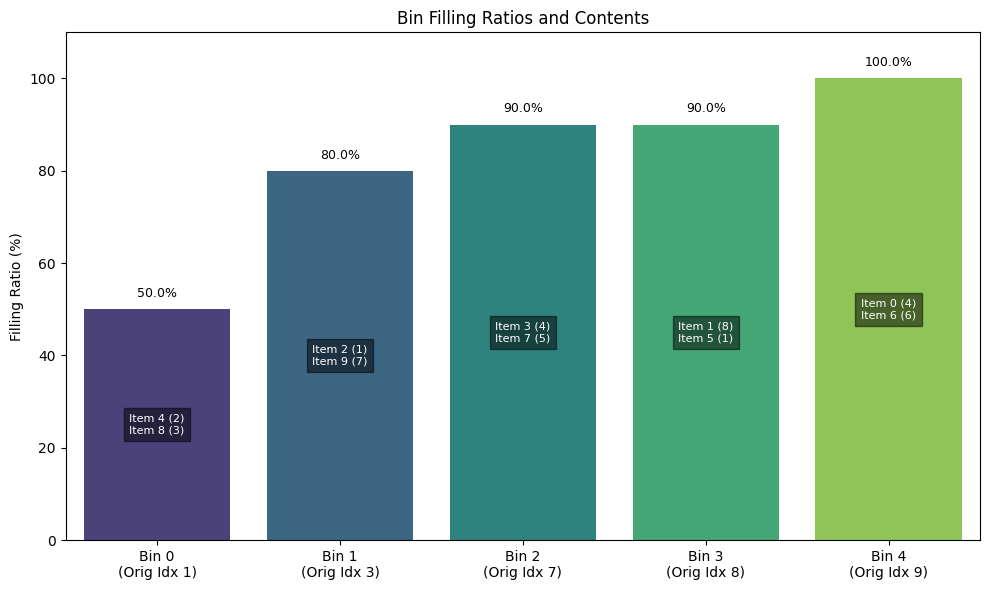

In [ ]:
#@title 結果の可視化
if status == mip.OptimizationStatus.OPTIMAL:
    # 結果の可視化 (どのアイテムがどのビンに入ったか)
    if model.objective_value is not None and model.objective_value > 0 :
        num_used_bins = int(model.objective_value)
        active_bin_indices = [j for j in range(num_bins) if y[j].x >= 0.99]

        # 充填率の計算と表示
        bin_labels = []
        filling_ratios = []
        item_details_for_plot = []

        plt.figure(figsize=(max(10, num_used_bins * 1.5), 6)) # ビン数に応じて幅を調整

        bin_plot_idx = 0
        for j in active_bin_indices:
            items_in_this_bin = []
            weights_in_this_bin = []
            weight_sum = 0
            for i in range(num_items):
                if x[i][j].x >= 0.99:
                    items_in_this_bin.append(f"Item {i} ({item_weights[i]})")
                    weights_in_this_bin.append(item_weights[i])
                    weight_sum += item_weights[i]

            if not items_in_this_bin: # 中身が空のビンはスキップ（y_jが1でもx_ijが全て0の場合）
                continue

            bin_labels.append(f"Bin {bin_plot_idx}\n(Orig Idx {j})")
            filling_ratios.append(weight_sum / bin_capacity * 100)
            item_details_for_plot.append(items_in_this_bin)
            bin_plot_idx += 1


        sns.barplot(x=bin_labels, y=filling_ratios, palette="viridis", hue=bin_labels, dodge=False, legend=False) # hueとdodgeで各バーに異なる色、凡例なし
        plt.ylabel("Filling Ratio (%)")
        plt.title("Bin Filling Ratios and Contents")
        plt.ylim(0, 110) # 100%を少し超えるようにして見やすくする

        # 各バーに中身のアイテムを表示
        for i, bin_label in enumerate(bin_labels):
            details = "\n".join(item_details_for_plot[i])
            plt.text(i, filling_ratios[i] / 2 , details, ha='center', va='center', color='white', fontsize=8, bbox=dict(facecolor='black', alpha=0.5))
            plt.text(i, filling_ratios[i] + 2, f"{filling_ratios[i]:.1f}%", ha='center', va='bottom', color='black', fontsize=9)

        plt.tight_layout()
        plt.show()

elif status == mip.OptimizationStatus.INFEASIBLE:
    print("実行不可能: 解が存在しません。")
elif status == mip.OptimizationStatus.NO_SOLUTION_FOUND:
    print("解が見つかりませんでした（時間制限など）。")
else:
    print(f"最適化ステータス: {status}")

### 求解結果の解釈と可視化について

上記のコードでは、`model.optimize()` が `mip.OptimizationStatus.OPTIMAL` を返した場合、最適解が見つかったことを意味する。`model.objective_value` には目的関数の最適値（この場合は最小ビン数）が格納される。
各変数 $x_{ij}$ および $y_j$ の最適値は、それぞれ
```
x[i][j].x
```
および
```
y[j].x
```
としてアクセスできる。これらは $0$ または $1$ をとる。
（実際の計算には誤差が含まれるため、厳密に数値で0か1にはならないが、
非常に近い数値として計算される）

結果の表示部分では、どのビンが使用され ($y_j \approx 1$)、
各使用ビンにどのアイテムが格納されているか ($x_{ij} \approx 1$)
をリストアップしている。

### 最適解の性質

上のビンパッキング問題の場合、目的関数はビンの数であり、
その最小値は5個と計算された。
ただし、具体的なアイテムの詰め方は他にも考えられる（場合もある）。
一般に、最適な値（この場合はビンの数）が求められても、
最適化が複数存在する場合があることに注意が必要である。
また、最適解が複数ある場合において、
全ての最適解を列挙することは数学的に複雑な操作が必要となる。
詳細は、講義の範囲を超えるのでここでは省略する。


### モデルの改善に関する簡単な視点

ビンパッキング問題はNP困難であるため、大規模な問題に対して厳密解を求めるには時間がかかりすぎることがある。そのような場合、以下のようなアプローチが考えられる。

  * **対称性の排除**:
      * 現在のモデルでは、例えばビン0とビン1が全く同じように使われる解は、ビン0とビン1の役割を入れ替えただけの別の解として扱われる。このような対称性があると、ソルバーの探索空間が無駄に広がる。
      * 例えば、$y\_j \\ge y\_{j+1}$ のような制約を追加して、番号の若いビンから優先的に使うようにすることで、対称性を一部排除することで、計算の効率化につながる場合もある。
  * **ビンの最大数の見積もり**:
      * 使用するビンの数 $m$ の上限をよりタイトに設定できれば、変数の数を減らせる。例えば、アイテムの総重量をビンの容量で割った値（小数点以下切り上げ）は、必要なビン数の下限を与える。この不等式を追加しても構わない。


---
#演習問題

各問題について、Python MIP を用いて解を求め、
最小ビン数を解答せよ。

-----
##演習問題 1

以下の条件でビンパッキング問題を解け。

  * アイテムのサイズ: $W = [2, 5, 4, 7, 1, 3, 8]$
  * ビンの容量: $C = 10$

-----
##演習問題 2

以下の条件でビンパッキング問題を解け。

  * アイテムのサイズ: $W = [2, 5, 4, 7, 1, 3, 8]$ （演習問題1と同じ）
  * ビンの容量: $C = 12$

-----
##演習問題 3

演習問題1の条件に加え、以下の制約が追加された問題を解け。
「アイテム0（サイズ2）とアイテム6（サイズ8）は、同じビンに入れてはならない。」

  * アイテムのサイズ: $W = [2, 5, 4, 7, 1, 3, 8]$
  * ビンの容量: $C = 10$
  * 追加制約: アイテム0とアイテム6は別々のビンに入れる。

-----
##演習問題 4

演習問題1の条件に加え、各ビンには最大で2個までしかアイテムを入れられないという制約がある場合の問題を解け。

  * アイテムのサイズ: $W = [2, 5, 4, 7, 1, 3, 8]$
  * ビンの容量: $C = 10$
  * 追加制約: 各ビンに入れられるアイテムの最大数は2個。

-----
##演習問題 5

アイテムには「通常品」と「壊れ物」の2種類があるとする。演習問題1のアイテムについて、以下のようにカテゴリ分けされている。
各ビンには「壊れ物」を最大1つまでしか入れられないという制約のもと、最小ビン数を求めよ。

  * アイテムのサイズ: $W = [2, 5, 4, 7, 1, 3, 8]$
  * アイテムのカテゴリ: `categories = ["通常品", "壊れ物", "通常品", "壊れ物", "通常品", "通常品", "壊れ物"]`
      * アイテム0 (サイズ2): 通常品
      * アイテム1 (サイズ5): 壊れ物
      * アイテム2 (サイズ4): 通常品
      * アイテム3 (サイズ7): 壊れ物
      * アイテム4 (サイズ1): 通常品
      * アイテム5 (サイズ3): 通常品
      * アイテム6 (サイズ8): 壊れ物
  * ビンの容量: $C = 10$
  * 追加制約: 各ビンに入れられる「壊れ物」カテゴリのアイテムは最大1個。

-----
